In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression as LogReg
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display, HTML
import graphviz
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from ipywidgets import interact
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)

In [2]:
# used to ignore warnings

import warnings; warnings.simplefilter('ignore')

In [3]:
test0 = pd.read_csv('https://raw.githubusercontent.com/SeanAntosiak/DS-Unit-2-Regression-Classification/master/data/tanzania/test_features.csv')
train0 = pd.read_csv('https://raw.githubusercontent.com/SeanAntosiak/DS-Unit-2-Regression-Classification/master/data/tanzania/train_features.csv')
trainLabels = pd.read_csv('https://raw.githubusercontent.com/SeanAntosiak/DS-Unit-2-Regression-Classification/master/data/tanzania/train_labels.csv')
sample = pd.read_csv('https://raw.githubusercontent.com/SeanAntosiak/DS-Unit-2-Regression-Classification/master/data/tanzania/sample_submission.csv')

In [4]:
train0.head(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [5]:
# checks if quantity column is a duplicate
# since there are no rows where the two are not equal
# I will drop one of the rows later

train0[train0['quantity']!=train0['quantity_group']][['quantity','quantity_group']].head()

,quantity,quantity_group


In [6]:
# checks if payment column is a duplicate
# it is not but they convey the same information 
# I will drop one of the rows later

train0[train0['payment']!=train0['payment_type']][['payment','payment_type']].head()

,payment,payment_type
0,pay annually,annually
2,pay per bucket,per bucket
5,pay per bucket,per bucket
11,pay when scheme fails,on failure
13,pay monthly,monthly


In [7]:
# checks if quantity colunm is a duplicate
# they look to convey the same information 
# will look further to see if I should drop

train0[train0['scheme_management']!=train0['management']][['scheme_management','management']].head()

,scheme_management,management
0,VWC,vwc
1,Other,wug
2,VWC,vwc
3,VWC,vwc
4,NaN,other


In [8]:
# checking occurances of each value

train0['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [9]:
# close to the same values as the other column,
# I will just keep one of these columns

train0['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [10]:
# looking at how these three columns relate
# it looks as if source and source_type represent the same thing
# but source_class is a more broad classification from 2 catagories
# I will drop the source column later
 
train0[train0['source_type']!=train0['source']][['source','source_type','source_class']].head(10)


,source,source_type,source_class
3,machine dbh,borehole,groundwater
6,machine dbh,borehole,groundwater
8,machine dbh,borehole,groundwater
10,machine dbh,borehole,groundwater
15,machine dbh,borehole,groundwater
16,river,river/lake,surface
17,river,river/lake,surface
22,river,river/lake,surface
23,river,river/lake,surface
26,machine dbh,borehole,groundwater


In [11]:
# checking to see if waterpoint type is a duplicate col
# need to check further

train0[train0['waterpoint_type_group']!=train0['waterpoint_type']][['waterpoint_type_group','waterpoint_type']].head(10)

,waterpoint_type_group,waterpoint_type
2,communal standpipe,communal standpipe multiple
3,communal standpipe,communal standpipe multiple
5,communal standpipe,communal standpipe multiple
53,communal standpipe,communal standpipe multiple
55,communal standpipe,communal standpipe multiple
62,communal standpipe,communal standpipe multiple
75,communal standpipe,communal standpipe multiple
89,communal standpipe,communal standpipe multiple
95,communal standpipe,communal standpipe multiple
96,communal standpipe,communal standpipe multiple


In [12]:
# checking values for waterpoint group

train0['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [13]:
# this column apears to have communal standpipe split into two seperate columns
# I will keep this column and drop the other

train0['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [14]:
# looking at how these three columns relate
# its hard to tell but type_class seems to be the most broad 
# and extraction_type the most spesific
# I will look a little more before deciding to drop anything
 
train0[train0['extraction_type']!=train0['extraction_type_group']][['extraction_type','extraction_type_group','extraction_type_class']].head()

,extraction_type,extraction_type_group,extraction_type_class
31,ksb,submersible,submersible
45,windmill,wind-powered,wind-powered
66,other - rope pump,rope pump,rope pump
88,ksb,submersible,submersible
92,ksb,submersible,submersible


In [15]:
# checking how many rows have different values for two of the columns
# it is a pretty big number, but even so most of the values are still 
# matched up pretty consistently (example: ksb is always matched with submersible)
# i will compare this shape to the size of the total Dataframe 

train0[train0['extraction_type']!=train0['extraction_type_group']][['extraction_type','extraction_type_group','extraction_type_class']].shape

(2469, 3)

In [16]:
# the last columns are only a small portion of the total
# I will drop the later two columns for now
# I may add them back if needed later

train0.shape

(59400, 40)

In [17]:
# checking if row is duplicate
# not enough information yet to decide on droping

train0[['water_quality', 'quality_group']].head()

,water_quality,quality_group
0,soft,good
1,soft,good
2,soft,good
3,soft,good
4,soft,good


In [18]:
# checking value counts of water quality column when the columns dont have the same values

train0[train0['water_quality']!=train0['quality_group']][['water_quality','quality_group']]['water_quality'].value_counts()

soft                  50818
coloured                490
salty abandoned         339
fluoride abandoned       17
Name: water_quality, dtype: int64

In [19]:
# looks the same as the last column but changes soft to good.
# I will drop the water_quality column

train0[train0['water_quality']!=train0['quality_group']][['water_quality','quality_group']]['quality_group'].value_counts()

good        50818
colored       490
salty         339
fluoride       17
Name: quality_group, dtype: int64

In [20]:
# only one value, will remove column

train0['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [21]:
# check what percentage of pumps work

trainLabels['status_group'].value_counts(normalize=True)

# since ~54.3% of pumps work, a baseline model of always guessing yes would have an accuracy of 54.3%

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [22]:
# checking if a population of 0 is reasonable or likely just missing information

train0[train0['population']==0].head()

# since most of the time a row with a population of 0 also has a amount tsh,
# and a gps height of 0 I will assume this is missing infromation and 
# will replace the 0 values with nan later

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,Internal,Ishinabulandi,Shinyanga,17,3,Shinyanga Rural,Samuye,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
7,54551,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,Tushirikiane,0,Lake Tanganyika,Nyawishi Center,Shinyanga,17,3,Kahama,Chambo,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
8,53934,0.0,2012-11-03,Wateraid,0,Water Aid,32.711100,-5.146712,Kwa Ramadhan Musa,0,Lake Tanganyika,Imalauduki,Tabora,14,6,Tabora Urban,Itetemia,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump
9,46144,0.0,2011-08-03,Isingiro Ho,0,Artisan,30.626991,-1.257051,Kwapeto,0,Lake Victoria,Mkonomre,Kagera,18,1,Karagwe,Kaisho,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


In [23]:
# checking if region corelates with region_code

train0[['region', 'region_code']]

# it looks as if it does, but region_code is a little more spesific
# I will drop the region_code column

,region,region_code
0,Iringa,11
1,Mara,20
2,Manyara,21
3,Mtwara,90
4,Kagera,18
5,Tanga,4
6,Shinyanga,17
7,Shinyanga,17
8,Tabora,14
9,Kagera,18


In [ ]:
# checks number of unique values for each feature compared to the unique values for that feature

dfUnique0 = pd.DataFrame()
dfUnique0['dtypes'] = train0.dtypes
dfUnique0['unique_values'] = train0.nunique()
dfUnique0

# id is not a continuous variable, and its variance is too high so I will remove the column
# other values have to high of varience and I will adress that later

In [ ]:
# creates train and test split

Xtrain0, Xval0, ytrain0, yval0 = tts(train0, trainLabels['status_group'], train_size=0.85, test_size=0.15, random_state=8)

In [ ]:
# checks all columns

Xtrain0.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [ ]:
# creates a function to wrangle an input dataframe and returns wrangled dataframe

def wrangle1(DF):
    
    # creates a copy of the input dataframe
    df = DF.copy()
    
    # removes colums refererenced earlier
    df = df.drop(columns=['id', 'recorded_by', 'quantity_group', 'region_code', 'payment', 'management',
                          'source', 'waterpoint_type_group', 'extraction_type_group', 
                          'extraction_type_class', 'water_quality'])
    
    # converts date_recorded to a year
    df['date_recorded'] = pd.to_datetime(df['date_recorded'], infer_datetime_format=True).dt.year
    
    # defines the columns which apear to have missing values input as 0
    zeroCols = ['amount_tsh', 'longitude', 'latitude', 'gps_height', 'construction_year']
    
     # replaces tiny latitude values with 0 to be replaced with nan in the next step 
    df['latitude']=df['latitude'].replace(-2e-8,0)
    
    # replaces missing 0 values with nan
    for col in zeroCols:
        df[col] = df[col].replace(0, np.nan)
        #df[col+'_missing']=df[col].isnull();
    
    
    # creates a list of columns to be grouped
    groupCols = ['funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name']
    
    # renames all values not in the top 20 most common values for a given row to be "other"
    for col in groupCols:
        top20 = df[col].value_counts()[:20].index
        df.loc[~df[col].isin(top20), col] = 'other';
    
        
    return(df);

In [ ]:
# applies wrangle function to each dataframe

Xtrain1 = wrangle1(Xtrain0)
Xval1 = wrangle1(Xval0)
Xtest1 = wrangle1(test0)

In [ ]:
# checks number to see if features got converted correctly

dfUnique1 = pd.DataFrame()
dfUnique1['dtypes'] = Xtrain1.dtypes
dfUnique1['unique_values'] = Xtrain1.nunique()
dfUnique1

,dtypes,unique_values
amount_tsh,float64,96
date_recorded,int64,5
funder,object,21
gps_height,float64,2413
installer,object,21
longitude,float64,48899
latitude,float64,48899
wpt_name,object,21
num_private,int64,60
basin,object,9


In [ ]:
Xtrain1.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,management_group,payment_type,quality_group,quantity,source_type,source_class,waterpoint_type
276,NaN,2011,Dhv,326.0,DWE,36.365529,-8.779055,other,0,Rufiji,other,Morogoro,4,other,other,1,True,Water Board,other,True,1995.0,gravity,user-group,never pay,good,enough,river/lake,surface,communal standpipe
10645,NaN,2013,other,1637.0,other,35.474487,-4.470856,other,0,Internal,other,Manyara,2,other,other,452,True,VWC,other,True,2001.0,gravity,user-group,never pay,good,insufficient,spring,groundwater,communal standpipe
22664,NaN,2013,other,1362.0,other,36.705153,-2.731092,Shuleni,0,Internal,Madukani,Arusha,6,other,other,400,True,Parastatal,other,NaN,2008.0,gravity,parastatal,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe
40640,NaN,2011,Kkkt,1241.0,KKKT,38.455936,-4.905352,other,15,Pangani,other,Tanga,1,other,other,1,True,VWC,other,True,1975.0,gravity,user-group,never pay,good,enough,spring,groundwater,communal standpipe
7092,NaN,2013,other,-33.0,other,40.185475,-10.270073,other,0,Ruvuma / Southern Coast,other,Mtwara,5,other,other,1200,False,Private operator,other,True,2006.0,submersible,commercial,never pay,good,enough,borehole,groundwater,other


In [ ]:
# creates a pipeline for a decision tree after using one hot encoding

pipe1 = make_pipeline(
    make_pipeline(
        ce.OneHotEncoder(use_cat_names=True),
        SimpleImputer(strategy='mean'),
        MinMaxScaler(), 
    ),
DecisionTreeClassifier(random_state=8)
)

In [ ]:
# fits pipeline and scores it

pipe1.fit(Xtrain1, ytrain0)

pipe1.score(Xval1, yval0)

0.7618406285072952

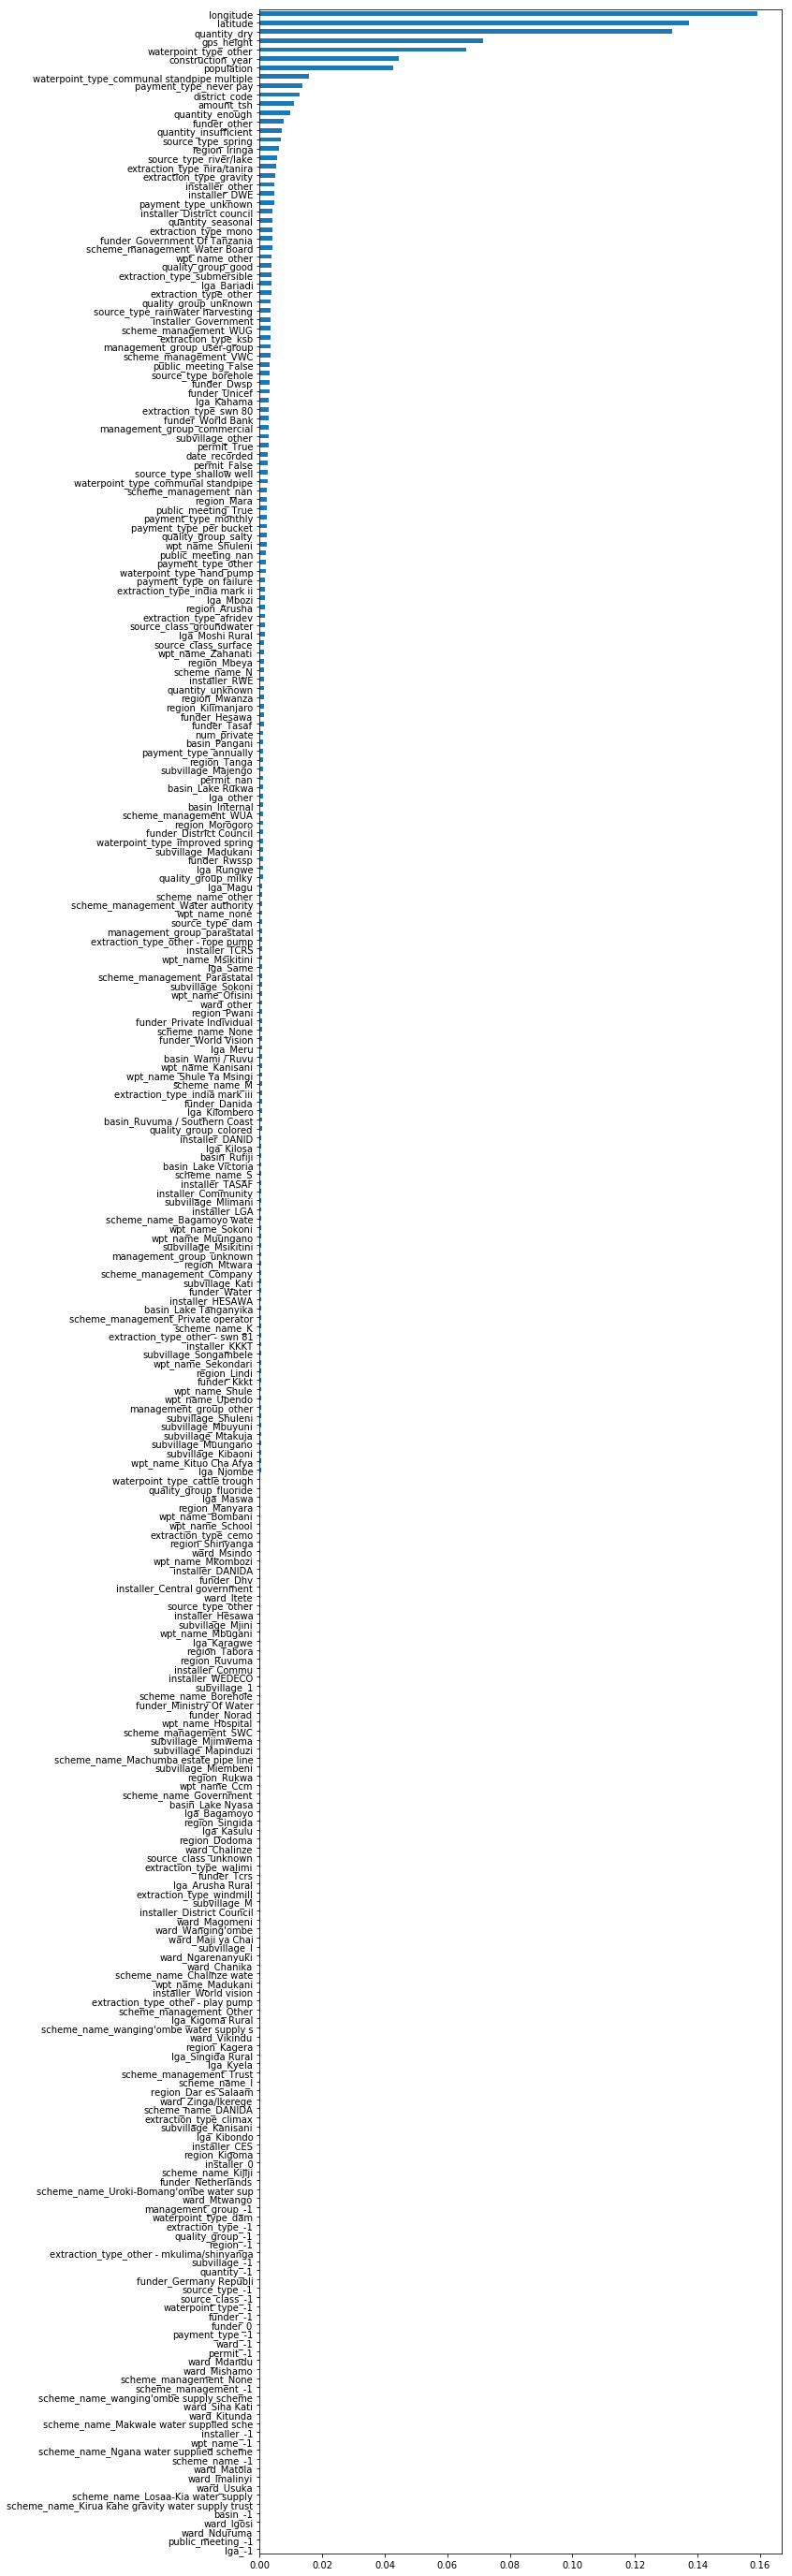

In [ ]:
# shows importance values for decision tree

mod1 = pipe1.named_steps['decisiontreeclassifier']
encoder1 = pipe1.named_steps['pipeline'].named_steps['onehotencoder']
encodedCols = encoder1.fit_transform(Xtrain1).columns
importance1 = pd.Series(mod1.feature_importances_, encodedCols)
plt.figure(figsize=(10,50))
importance1.sort_values().plot.barh();

In [ ]:
# creates a function to wrangle an input dataframe and returns wrangled dataframe

def wrangle2(DF):
    
    # creates a copy of the input dataframe
    df = DF.copy()
                    
    # converts date_recorded to a year
    df['date_recorded'] = pd.to_datetime(df['date_recorded'], infer_datetime_format=True).dt.year
    
    # defines the columns which apear to have missing values input as 0
    zeroCols = ['amount_tsh', 'longitude', 'latitude', 'gps_height', 'construction_year']
    
     # replaces tiny latitude values with 0 to be replaced with nan in the next step 
    df['latitude']=df['latitude'].replace(-2e-8,0)
    
    # replaces missing 0 values with nan
    for col in zeroCols:
        df[col] = df[col].replace(0, np.nan)
        df[col+'_missing']=df[col].isnull();
       
        
    return(df);

In [ ]:
# applies wrangle function to each dataframe

Xtrain2 = wrangle2(Xtrain0)
Xval2 = wrangle2(Xval0)
Xtest2 = wrangle2(test0)

In [ ]:
# creates a second pipeline for a random forest with ordinal encoding

pipe2 = make_pipeline(
    make_pipeline(
        ce.OrdinalEncoder(),
        SimpleImputer(strategy='median'),
        MinMaxScaler(), 
    ),
RandomForestClassifier(n_estimators=1000, random_state=8, n_jobs=-1)
)

In [ ]:
# fits second pipeline and scores it

pipe2.fit(Xtrain2, ytrain0)

pipe2.score(Xval2, yval0)

0.8117845117845118

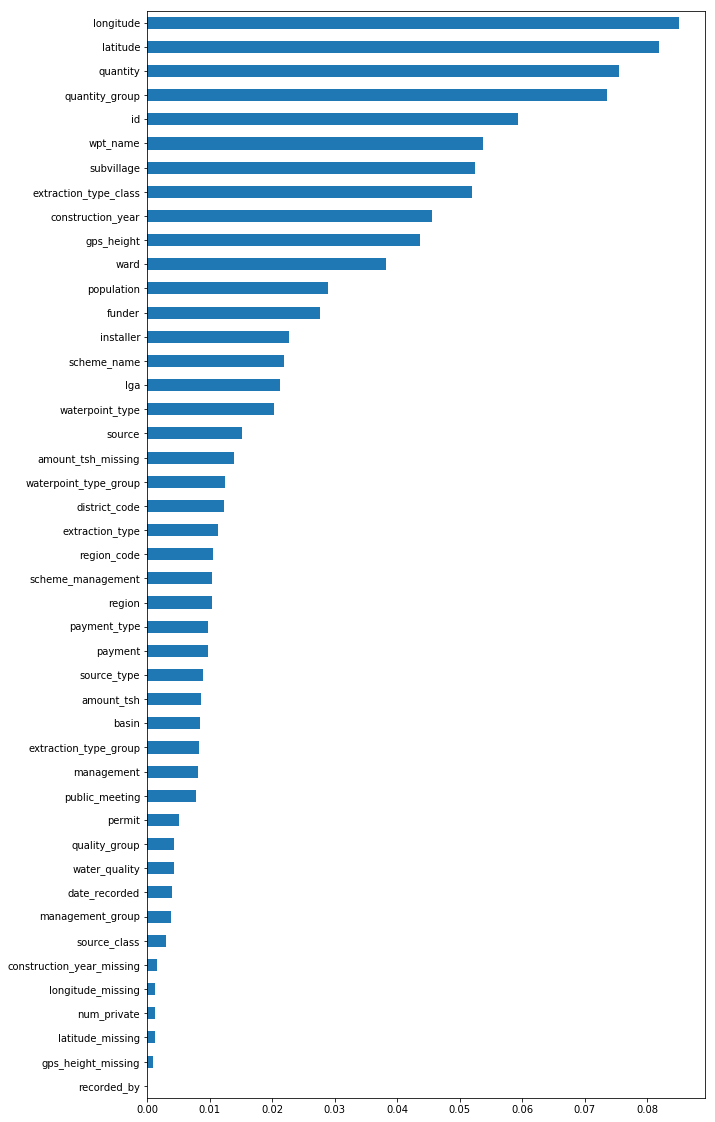

In [ ]:
# shows importance values for random forest

mod2 = pipe2.named_steps['randomforestclassifier']
Cols2 = Xtrain2.columns
importance2 = pd.Series(mod2.feature_importances_, Cols2)
plt.figure(figsize=(10,20))
importance2.sort_values().plot.barh();

In [ ]:
# creates predictions from test data using pipe2 and entire training data set

pipe2.fit(wrangle2(train0), trainLabels['status_group'])
pred3 = pipe2.predict(wrangle2(test0))

In [ ]:
# creating a submission dataframe

submission3 = sample.copy()
submission3['status_group'] = pred3

In [ ]:
# creates submission file for challenge

submission3.to_csv('submission3.csv', index=False)